# MIDS - w261 Machine Learning At Scale


## Project 5 - Phase 2 (Altiscale cluster)


---
__Name:__  Hyera Moon    
__Week:__   5


# Table of Contents <a name="TOC"></a> 

1.  [HW Instructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
       
    5.4.  [HW5.4](#5.4)    
    5.5.  [HW5.5](#5.5)    
    5.6.  [HW5.6](#5.6)    
    5.7.  [HW5.7](#5.7)    
    5.8.  [HW5.8](#5.8)    
    5.9.  [HW5.9](#5.9)    
   

<a name="1"></a>
# 1 Instructions
[Back to Table of Contents](#TOC)



<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* See async and live lectures for this week

<a name="3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

<a name="5.4"></a> 
# PHASE 2
----------

# HW 5.4   
## Full-scale experiment on Google N-gram data on the CLOUD
__ Once you are happy with your test results __ proceed to generating  your results on the Google n-grams dataset. 

## 3.  HW5.4.0  <a name="5.4.0"></a> Run systems tests on the CLOUD  (PHASE 2)
[Back to Table of Contents](#TOC)

Repeat HW5.3.0 (using the same small data sources that were used in HW5.3.0) on ** the cloud** (e.g., AltaScale / AWS/ SoftLayer/ Azure). Make sure all tests give correct results! Good luck out there!

#### MRJob codes from phase 1

In [1]:
%%writefile buildStripes.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
import itertools
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.job import MRStep

class MRbuildStripes(MRJob):
  
  #START SUDENT CODE531_STRIPES
    def steps(self):
        return[
            MRStep(
                mapper_init = self.mapper_init,
                mapper = self.mapper,
                reducer = self.reducer
            )
        ]
    
    def mapper_init(self):
        self.stripes = {}
        
    def mapper(self, _, line):
        line = line.strip().lower()
        ngram, count, other = line.split('\t',2)
        count = int(count)
        words = ngram.split(' ')
        self.stripes = {}
                
        for subset in itertools.permutations(sorted(words), 2):  #instead of combinations to keep symmetry
            if subset[0] == subset[1]:  # in case two same words in a line
                continue
            elif subset[0] not in self.stripes.keys():
                self.stripes[subset[0]] = {}
                self.stripes[subset[0]][subset[1]] = count
            elif subset[1] not in self.stripes[subset[0]]:
                self.stripes[subset[0]][subset[1]] = count
            else:
                self.stripes[subset[0]][subset[1]] += count

        for key in self.stripes.keys():
            yield key, self.stripes[key]
            
        
    def reducer(self, key, values):
        temp_stripes = {}
        for value in values:
            for word, count in value.items():
                temp_stripes[word] = temp_stripes.get(word,0) + count
        yield key, temp_stripes
  

  #END SUDENT CODE531_STRIPES   
    
if __name__ == '__main__':
    MRbuildStripes.run()

Overwriting buildStripes.py


In [3]:
%%writefile invertedIndex.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-


from __future__ import division
import collections
import re
import json
import math
#import numpy as np commented since not supported by Hadoop Python version
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.protocol import JSONProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRinvertedIndex(MRJob):
    INPUT_PROTOCOL = JSONProtocol

  #START SUDENT CODE531_INV_INDEX
    def steps(self):
        return[
            MRStep(
                mapper=self.mapper,
                reducer=self.reducer
            )
        ]
    
    def mapper(self, key_word, stripes):
        words = stripes.keys()
        _len = len(words)
        for word in words:
        # Store the length of the document to use with JACCARD (|A| + |B|)
            yield word, (key_word, _len)
        
    def reducer(self, word, values):        
        d = collections.defaultdict(list)
        for value in values:
            d[word].append(value)
        yield word,d[word]

  #END SUDENT CODE531_INV_INDEX
        
if __name__ == '__main__':
    MRinvertedIndex.run() 

Overwriting invertedIndex.py


In [4]:
%%writefile similarity.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
#import numpy as np  commented since not supported by Hadoop Python version
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRsimilarity(MRJob):
  
  #START SUDENT CODE531_SIMILARITY
    MRJob.SORT_VALUES
    
    def steps(self):
        JOBCONF_STEP1 = {}
        JOBCONF_STEP2 = { 
                # Must use -r hadoop mode for this sorting to work #
                'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                'mapreduce.partition.keycomparator.options':'-k1,1nr',
        }

        return [
            MRStep(jobconf=JOBCONF_STEP1,
                   mapper = self.mapper_pair_sim,
                   reducer = self.reducer_pair_sim
                  ),
            MRStep(jobconf=JOBCONF_STEP2,
                  mapper=None,
                  reducer=self.reducer_sort)
        ]
        
    def mapper_pair_sim(self, _, line):
        line = line.strip()
        index,posting = line.split("\t")
        posting = json.loads(posting)
        
        X = map(lambda x: x[0]+"."+str(x[1]) , posting)
        
        # taking advantage of symetry, output only (a,b), but not (b,a)
        for subset in itertools.combinations(sorted(set(X)), 2):
            yield subset[0]+"."+subset[1], 1
        
            
    def reducer_pair_sim(self,key,values):
        word1, word1_len, word2, word2_len = key.split(".")
        t =sum(values)
       
        cosine = (1.0/(float(word1_len)**0.5) * 1.0/(float(word2_len)**0.5))*t
        jaccard = t / ( int(word1_len) + int(word2_len) - t )
        overlap = t / min(int(word1_len), int(word2_len))
        dice = 2 * t / ( int(word1_len) + int(word2_len))
        avg = (jaccard + cosine + overlap + dice) / 4
        
        # rounding to 6 decimals
        avg = round(avg, 6)
        cosine = round(cosine, 6)
        jaccard = round(jaccard, 6)
        overlap = round(overlap, 6)
        dice = round(dice, 6)
        
        yield avg, (word1+" - "+word2, cosine, jaccard, overlap, dice)
    
    
    def reducer_sort(self,key,values):
        for value in values:
            yield key, value

  #END SUDENT CODE531_SIMILARITY
  
if __name__ == '__main__':
    MRsimilarity.run()

Overwriting similarity.py


In [5]:
!chmod a+x buildStripes.py
!chmod a+x invertedIndex.py
!chmod a+x similarity.py

#### Run Systems tests on CLOUD on small datasets

#### (1) build stripes for all the test data sets

In [6]:
###########################################################################
# Make Stripes from ngrams for systems test 1
###########################################################################

!hdfs dfs rm --recursive systems_test_stripes_1
!python buildStripes.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > systems_test_stripes_1

rm: Unknown command
Did you mean -rm?  This command begins with a dash.
No configs found; falling back on auto-configuration
Creating temp directory /tmp/buildStripes.hyeramoon.20170219.222028.820956
Running step 1 of 1...
Streaming final output from /tmp/buildStripes.hyeramoon.20170219.222028.820956/output...
Removing temp directory /tmp/buildStripes.hyeramoon.20170219.222028.820956...


In [7]:
!cat systems_test_stripes_1

"for"	{"a": 59, "bill": 59, "religious": 59, "establishing": 59}
"forms"	{"a": 116, "of": 232, "collection": 116}
"general"	{"a": 92, "of": 92, "george": 92, "biography": 92}
"george"	{"a": 92, "of": 92, "biography": 92, "general": 92}
"government"	{"a": 102, "case": 102, "study": 102, "in": 102}
"in"	{"a": 1201, "case": 102, "government": 102, "study": 102, "child's": 1099, "wales": 1099, "christmas": 1099}
"limited"	{"a": 55, "case": 55, "study": 55, "of": 55}
"narrative"	{"a": 62, "of": 62, "the": 62, "circumstantial": 62}
"of"	{"a": 1011, "case": 502, "circumstantial": 62, "george": 92, "limited": 55, "tales": 123, "collection": 355, "the": 62, "forms": 232, "female": 447, "narrative": 62, "fairy": 123, "general": 92, "study": 502, "biography": 92}
"religious"	{"a": 59, "bill": 59, "for": 59, "establishing": 59}
"sea"	{"a": 62, "city": 62, "the": 62, "by": 62}
"study"	{"a": 604, "case": 604, "limited": 55, "government": 102, "of": 502, "female": 447, "in": 102}
"tales"	{"a": 123, "

In [8]:
###########################################################################
# Make Stripes from ngrams for systems test 2
###########################################################################

!hdfs dfs rm --recursive systems_test_stripes_2
!python buildStripes.py -r local atlas-boon-systems-test.txt > systems_test_stripes_2

rm: Unknown command
Did you mean -rm?  This command begins with a dash.
No configs found; falling back on auto-configuration
Creating temp directory /tmp/buildStripes.hyeramoon.20170219.222129.200308
Running step 1 of 1...
Streaming final output from /tmp/buildStripes.hyeramoon.20170219.222129.200308/output...
Removing temp directory /tmp/buildStripes.hyeramoon.20170219.222129.200308...


In [9]:
!cat systems_test_stripes_2

"cava"	{"dipped": 10, "boon": 10}
"dipped"	{"atlas": 15, "boon": 10, "cava": 10}
"atlas"	{"dipped": 15, "boon": 50}
"boon"	{"atlas": 50, "dipped": 10, "cava": 10}


In [10]:
########################################################################
# Stripes for systems test 3 (given, no need to build stripes)
########################################################################

with open("systems_test_stripes_3", "w") as f:
    f.writelines([
        '"DocA"\t{"X":20, "Y":30, "Z":5}\n',
        '"DocB"\t{"X":100, "Y":20}\n',  
        '"DocC"\t{"M":5, "N":20, "Z":5, "Y":1}\n'
    ])
!cat systems_test_stripes_3  

"DocA"	{"X":20, "Y":30, "Z":5}
"DocB"	{"X":100, "Y":20}
"DocC"	{"M":5, "N":20, "Z":5, "Y":1}


#### (2) Build Inverted Index

In [11]:
!python invertedIndex.py -r local systems_test_stripes_1 > systems_test_index_1

No configs found; falling back on auto-configuration
Creating temp directory /tmp/invertedIndex.hyeramoon.20170219.222223.143120
Running step 1 of 1...
Streaming final output from /tmp/invertedIndex.hyeramoon.20170219.222223.143120/output...
Removing temp directory /tmp/invertedIndex.hyeramoon.20170219.222223.143120...


In [12]:
!python invertedIndex.py -r local systems_test_stripes_2 > systems_test_index_2

No configs found; falling back on auto-configuration
Creating temp directory /tmp/invertedIndex.hyeramoon.20170219.222226.587406
Running step 1 of 1...
Streaming final output from /tmp/invertedIndex.hyeramoon.20170219.222226.587406/output...
Removing temp directory /tmp/invertedIndex.hyeramoon.20170219.222226.587406...


In [13]:
!python invertedIndex.py -r local systems_test_stripes_3 > systems_test_index_3

No configs found; falling back on auto-configuration
Creating temp directory /tmp/invertedIndex.hyeramoon.20170219.222229.778327
Running step 1 of 1...
Streaming final output from /tmp/invertedIndex.hyeramoon.20170219.222229.778327/output...
Removing temp directory /tmp/invertedIndex.hyeramoon.20170219.222229.778327...


In [14]:
##########################################################
# Pretty print systems tests for generating Inverted Index
##########################################################

import json

for i in range(1,4):
  print "—"*100
  print "Systems test ",i," - Inverted Index"
  print "—"*100  
  with open("systems_test_index_"+str(i),"r") as f:
      lines = f.readlines()
      for line in lines:
          line = line.strip()
          word,stripe = line.split("\t")
          stripe = json.loads(stripe)
          stripe.extend([["",""] for _ in xrange(3 - len(stripe))])

          print "{0:>16} |{1:>16} |{2:>16} |{3:>16}".format(
              (word), stripe[0][0]+" "+str(stripe[0][1]), stripe[1][0]+" "+str(stripe[1][1]), stripe[2][0]+" "+str(stripe[2][1]))
        


————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  1  - Inverted Index
————————————————————————————————————————————————————————————————————————————————————————————————————
           "for" |            a 27 |          bill 4 |  establishing 4
         "forms" |            a 27 |    collection 5 |           of 15
       "general" |            a 27 |     biography 4 |        george 4
        "george" |            a 27 |     biography 4 |       general 4
    "government" |            a 27 |          case 7 |            in 7
            "in" |            a 27 |          case 7 |       child's 4
       "limited" |            a 27 |          case 7 |           of 15
     "narrative" |            a 27 |circumstantial 4 |           of 15
            "of" |            a 27 |     biography 4 |          case 7
     "religious" |            a 27 |          bill 4 |  establishing 4
           "sea" |            a 27 |            by 4 |

#### (3) Calculate similarities

In [19]:
!python similarity.py -r hadoop systems_test_index_1 --no-output --cleanup NONE

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Creating temp directory /tmp/similarity.hyeramoon.20170219.224117.065301
Copying local files to hdfs:///user/hyeramoon/tmp/mrjob/similarity.hyeramoon.20170219.224117.065301/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob5883782439861210703.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connectin

In [21]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob/similarity.hyeramoon.20170219.224117.065301/output

Found 2 items
-rw-r--r--   3 hyeramoon users          0 2017-02-19 22:42 /user/hyeramoon/tmp/mrjob/similarity.hyeramoon.20170219.224117.065301/output/_SUCCESS
-rw-r--r--   3 hyeramoon users      31512 2017-02-19 22:42 /user/hyeramoon/tmp/mrjob/similarity.hyeramoon.20170219.224117.065301/output/part-00000


In [22]:
!hdfs dfs -cat /user/hyeramoon/tmp/mrjob/similarity.hyeramoon.20170219.224117.065301/output/part-00000 > systems_test_similarities_1

In [23]:
!python similarity.py -r hadoop systems_test_index_2 --no-output --cleanup NONE

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Creating temp directory /tmp/similarity.hyeramoon.20170219.224638.072782
Copying local files to hdfs:///user/hyeramoon/tmp/mrjob/similarity.hyeramoon.20170219.224638.072782/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob6518462995055801996.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connectin

In [24]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob/similarity.hyeramoon.20170219.224638.072782/output

Found 2 items
-rw-r--r--   3 hyeramoon users          0 2017-02-19 22:47 /user/hyeramoon/tmp/mrjob/similarity.hyeramoon.20170219.224638.072782/output/_SUCCESS
-rw-r--r--   3 hyeramoon users        451 2017-02-19 22:47 /user/hyeramoon/tmp/mrjob/similarity.hyeramoon.20170219.224638.072782/output/part-00000


In [25]:
!hdfs dfs -cat /user/hyeramoon/tmp/mrjob/similarity.hyeramoon.20170219.224638.072782/output/part-00000 > systems_test_similarities_2

In [26]:
!python similarity.py -r hadoop systems_test_index_3 --no-output --cleanup NONE

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Creating temp directory /tmp/similarity.hyeramoon.20170219.224958.724819
Copying local files to hdfs:///user/hyeramoon/tmp/mrjob/similarity.hyeramoon.20170219.224958.724819/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob7216739956194548758.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connectin

In [27]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob/similarity.hyeramoon.20170219.224958.724819/output

Found 2 items
-rw-r--r--   3 hyeramoon users          0 2017-02-19 22:51 /user/hyeramoon/tmp/mrjob/similarity.hyeramoon.20170219.224958.724819/output/_SUCCESS
-rw-r--r--   3 hyeramoon users        328 2017-02-19 22:51 /user/hyeramoon/tmp/mrjob/similarity.hyeramoon.20170219.224958.724819/output/part-00000


In [28]:
!hdfs dfs -cat /user/hyeramoon/tmp/mrjob/similarity.hyeramoon.20170219.224958.724819/output/part-00000 > systems_test_similarities_3

In [29]:
############################################
# Pretty print systems tests FOR ALL TESTS 
############################################

import json
for i in range(1,4):
  print '—'*110
  print "Systems test ",i," - Similarity measures"
  print '—'*110
  print "{0:>15} |{1:>27} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
          "average", "pair", "cosine", "jaccard", "overlap", "dice")
  print '-'*110

  with open("systems_test_similarities_"+str(i),"r") as f:
      lines = f.readlines()
      for line in lines:
          line = line.strip()
          avg,stripe = line.split("\t")
          stripe = json.loads(stripe)

          print "{0:>15f} |{1:>27} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
              float(avg), stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]))
 

——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  1  - Similarity measures
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
        average |                       pair |         cosine |        jaccard |        overlap |           dice
--------------------------------------------------------------------------------------------------------------
       1.000000 |           female - limited |       1.000000 |       1.000000 |       1.000000 |       1.000000
       0.868292 |              forms - tales |       0.866025 |       0.750000 |       1.000000 |       0.857143
       0.868292 |              fairy - forms |       0.866025 |       0.750000 |       1.000000 |       0.857143
       0.830357 |               case - study |       0.857143 |       0.750000 |       0.857143 |       0.857143
       0.712500 |            child's - wales |       0.750000 |

## 3.  HW5.4.1 <a name="5.4.1"></a>Full-scale experiment: EDA of Google n-grams dataset (PHASE 2)
[Back to Table of Contents](#TOC)

Do some EDA on this dataset using mrjob, e.g., 

- A. Longest 5-gram (number of characters)
- B. Top 10 most frequent words (please use the count information), i.e., unigrams
- C. 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- D. Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

### HW5.4.1 - A. Longest 5-gram (number of characters)

In [23]:
%%writefile longest5gram.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class longest5gram(MRJob):
    
    # START STUDENT CODE 5.4.1.A
    
    MRJob.SORT_VALUES
    
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.reduces':'1'
        }
        return[
            MRStep(  
                jobconf = JOBCONF_STEP,  # One reducer to find the longest ngram 
                                         # since only input one line from each mapper
                mapper_init = self.mapper_init,
                mapper = self.mapper,
                mapper_final = self.mapper_final,
                reducer_init = self.reducer_init,
                reducer = self.reducer,
                reducer_final = self.reducer_final
            )
        ]
    
    
    def mapper_init(self):
        self.longest = ["NA", 0]
    
    
    def mapper(self, _, line):
        line = line.strip()
        ngram, other = line.split("\t",1)
        char_count = len(str(ngram))  # assuming white space between words counts as character
        if char_count > self.longest[1]:
            self.longest[1] = char_count
            self.longest[0] = ngram    
     
    
    def mapper_final(self):
        self.increment_counter('group', 'Num_mapper_calls', 1)
        yield self.longest[0], self.longest[1]
     
    
    def reducer_init(self):
        self.longest_final = ["NA", 0]
    
    
    def reducer(self, ngram, length):
        char_count = sum(length)
        if char_count > self.longest_final[1]:
            self.longest_final[1] = char_count
            self.longest_final[0] = ngram
            
            
    def reducer_final(self):
        self.increment_counter('group', 'Num_reducer_calls', 1)
        yield self.longest_final[0], self.longest_final[1]
        
        
    # END STUDENT CODE 5.4.1.A
    
if __name__ == '__main__':
    longest5gram.run()

Overwriting longest5gram.py


In [2]:
!chmod a+x longest5gram.py

__On test data set:__

In [24]:
!python longest5gram.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt --no-output --cleanup NONE

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Creating temp directory /tmp/longest5gram.hyeramoon.20170220.042755.907411
Copying local files to hdfs:///user/hyeramoon/tmp/mrjob/longest5gram.hyeramoon.20170220.042755.907411/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob7171140693008017713.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Conne

In [25]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob/longest5gram.hyeramoon.20170220.030239.025648/output

Found 2 items
-rw-r--r--   3 hyeramoon users          0 2017-02-20 03:03 /user/hyeramoon/tmp/mrjob/longest5gram.hyeramoon.20170220.030239.025648/output/_SUCCESS
-rw-r--r--   3 hyeramoon users         39 2017-02-20 03:03 /user/hyeramoon/tmp/mrjob/longest5gram.hyeramoon.20170220.030239.025648/output/part-00000


In [66]:
!hdfs dfs -cat /user/hyeramoon/tmp/mrjob/longest5gram.hyeramoon.20170220.030239.025648/output/part-00000 > \
longest5gram.txt
!cat longest5gram.txt

"A BILL FOR ESTABLISHING RELIGIOUS"	33


__On full data set:__

In [8]:
!hdfs dfs -ls /tmp/hw5b/

Found 1 items
-rw-r--r--   3 alenart hdfs 2156069116 2017-02-19 23:53 /tmp/hw5b/gigantor_file.txt


In [3]:
!time python longest5gram.py hdfs:///tmp/hw5b/gigantor_file.txt -r hadoop --no-output --cleanup NONE

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Creating temp directory /tmp/longest5gram.hyeramoon.20170222.171024.413003
Copying local files to hdfs:///user/hyeramoon/tmp/mrjob/longest5gram.hyeramoon.20170222.171024.413003/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob4774954619501297271.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Conne

In [28]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob/longest5gram.hyeramoon.20170220.042932.642153/output

Found 2 items
-rw-r--r--   3 hyeramoon users          0 2017-02-20 04:30 /user/hyeramoon/tmp/mrjob/longest5gram.hyeramoon.20170220.042932.642153/output/_SUCCESS
-rw-r--r--   3 hyeramoon users        166 2017-02-20 04:30 /user/hyeramoon/tmp/mrjob/longest5gram.hyeramoon.20170220.042932.642153/output/part-00000


In [39]:
!hdfs dfs -cat /user/hyeramoon/tmp/mrjob/longest5gram.hyeramoon.20170220.042932.642153/output/part-00000 > \
longest5gram.txt
!cat longest5gram.txt

"AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR"	159


In [68]:
!hdfs dfs -rm -r /user/hyeramoon/tmp/mrjob/longest5gram.hyeramoon.20170220.042932.642153/output

17/02/21 02:57:36 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/tmp/mrjob/longest5gram.hyeramoon.20170220.042932.642153/output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/.Trash/Current


## Report Stats: 

## Longest 5grams MR stats

    Altiscale Hadoop
    RUNNING for 135s ~= 2 minutes 

__Step 1:__  

    Map tasks = 8
    Reduce tasks = 1 

### HW5.4.1 - B. Top 10 most frequent words 

In [31]:
%%writefile mostFrequentWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostFrequentWords(MRJob):
    
    # START STUDENT CODE 5.4.1.B
        
    def steps(self):
        JOBCONF_STEPtest = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.job.reduces':'3'  # just testing with 3 reducers for small dataset - to be deleted for actual dataset
        }
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.job.reduces':'1'  # Note: one reducer suffice since each partition from previous MRJob only
                                      # emits 10 lines
        }
        return[
            MRStep(
                #jobconf = JOBCONF_STEPtest, # just testing many reducers for small dataset - to be deleted for actual dataset
                mapper = self.mapper,
                combiner = self.combiner,
                reducer_init = self.reducer_init,
                reducer = self.reducer,
                reducer_final = self.reducer_final
            ),
            MRStep(
                jobconf = JOBCONF_STEP,
                reducer_init = self.reducer_top10_init,
                reducer = self.reducer_top10,
                reducer_final = self.reducer_top10_final
            )

        ]
    
    
    def mapper(self, _, line):
        self.increment_counter('group', 'Num_mapper_calls', 1)
        ngram, count, other = line.strip().split('\t',2)
        words = ngram.split(" ")
        count = int(count)
        for word in words:
            yield str(word).lower(), count
           
        
    def combiner(self,word, counts):
        self.increment_counter('group', 'Num_combiner_calls', 1)
        yield word, sum(counts)
    
    
    def reducer_init(self):
        self.wordcounts_per_partition = [["None", 0]] * 10
            
                
    def reducer(self, word, counts):
        count = sum(counts)
        index = -1
        for i in range(10):
            if count > self.wordcounts_per_partition[i][1]:  # note: number in counts in increasing order
                index = i  # find where to insert the wordcount in the count list
            else:
                break
        if index != -1:
            self.wordcounts_per_partition.insert(index+1, [word, count])
            self.wordcounts_per_partition = self.wordcounts_per_partition[1:11]  # take the 10 items with largest count out of 11 items

        
    def reducer_final(self):
        self.increment_counter('group', 'Num_reducer_calls', 1)
        
        for i in range(9,-1,-1):
            yield self.wordcounts_per_partition[i][0], self.wordcounts_per_partition[i][1]  # top 10 most frequent words 
                                                                                            # per partition
    
        
    def reducer_top10_init(self):
        self.wordcounts_total = [["None", 0]] * 10
    
    
    def reducer_top10(self, word, counts):
        count = sum(counts)
        index = -1
        for i in range(10):
            if count > self.wordcounts_total[i][1]:  # note: number in counts in increasing order
                index = i  # find where to insert the wordcount in the count list
            else:
                break
        if index != -1:
            self.wordcounts_total.insert(index+1, [word, count])
            self.wordcounts_total = self.wordcounts_total[1:11]  # take the 10 items with largest count out of 11 items
            
            
    def reducer_top10_final(self):
        self.increment_counter('group', 'Num_reducer2_calls', 1)
        
        for i in range(9,-1,-1):
            yield self.wordcounts_total[i][0], self.wordcounts_total[i][1]  # top 10 most frequent words 
    
    
    # END STUDENT CODE 5.4.1.B
        
        
if __name__ == '__main__':
    mostFrequentWords.run()

Writing mostFrequentWords.py


In [32]:
!chmod a+x mostFrequentWords.py

__On the test data set:__

In [33]:
!python mostFrequentWords.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt \
--no-output --cleanup NONE

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Creating temp directory /tmp/mostFrequentWords.hyeramoon.20170220.043728.816288
Copying local files to hdfs:///user/hyeramoon/tmp/mrjob/mostFrequentWords.hyeramoon.20170220.043728.816288/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob9051497411254894967.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timelin

In [34]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob/mostFrequentWords.hyeramoon.20170220.043728.816288/output

Found 2 items
-rw-r--r--   3 hyeramoon users          0 2017-02-20 04:38 /user/hyeramoon/tmp/mrjob/mostFrequentWords.hyeramoon.20170220.043728.816288/output/_SUCCESS
-rw-r--r--   3 hyeramoon users        127 2017-02-20 04:38 /user/hyeramoon/tmp/mrjob/mostFrequentWords.hyeramoon.20170220.043728.816288/output/part-00000


In [69]:
!hdfs dfs -cat /user/hyeramoon/tmp/mrjob/mostFrequentWords.hyeramoon.20170220.043728.816288/output/part-00000 > \
mostFrequentWords_test.txt
!cat mostFrequentWords_test.txt

"a"	2217
"in"	1201
"child's"	1099
"christmas"	1099
"wales"	1099
"of"	1011
"case"	604
"study"	604
"female"	447
"collection"	239


In [70]:
!hdfs dfs -rm -r /user/hyeramoon/tmp/mrjob/mostFrequentWords.hyeramoon.20170220.043728.816288/output

17/02/21 02:59:26 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/tmp/mrjob/mostFrequentWords.hyeramoon.20170220.043728.816288/output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/.Trash/Current


__On the full data set:__

In [4]:
!time python mostFrequentWords.py -r hadoop hdfs:///tmp/hw5b/gigantor_file.txt --no-output --cleanup NONE

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Creating temp directory /tmp/mostFrequentWords.hyeramoon.20170222.171738.832016
Copying local files to hdfs:///user/hyeramoon/tmp/mrjob/mostFrequentWords.hyeramoon.20170222.171738.832016/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob5101050960391884442.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timelin

In [37]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob/mostFrequentWords.hyeramoon.20170222.171738.832016/output

Found 2 items
-rw-r--r--   3 hyeramoon users          0 2017-02-20 05:00 /user/hyeramoon/tmp/mrjob/mostFrequentWords.hyeramoon.20170220.044101.148817/output/_SUCCESS
-rw-r--r--   3 hyeramoon users        159 2017-02-20 05:00 /user/hyeramoon/tmp/mrjob/mostFrequentWords.hyeramoon.20170220.044101.148817/output/part-00000


In [38]:
!hdfs dfs -cat /user/hyeramoon/tmp/mrjob/mostFrequentWords.hyeramoon.20170222.171738.832016/output/part-00000 > \
mostFrequentWords.txt
!cat mostFrequentWords.txt

"the"	5490815394
"of"	3698583299
"to"	2227866570
"in"	1421312776
"a"	1361123022
"and"	1149577477
"that"	802921147
"is"	758328796
"be"	688707130
"as"	492170314


In [5]:
!hdfs dfs -rm -r /user/hyeramoon/tmp/mrjob/*

17/02/22 17:48:17 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/tmp/mrjob/longest5gram.hyeramoon.20170222.171024.413003' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/.Trash/Current
17/02/22 17:48:17 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/tmp/mrjob/mostFrequentWords.hyeramoon.20170222.171738.832016' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/.Trash/Current


## Most frequent words MR stats
    
    Altiscale Hadoop
    RUNNING for 1645s ~= 27 minutes 
    
__Step 1:__   
  
    Launched map tasks=8  
    Launched reduce tasks=1   

__Step 2:__  
    Launched map tasks=2 
    Launched reduce tasks=1 


### HW5.4.1 - C. 20 Most/Least densely appearing words 

In [1]:
%%writefile mostLeastDenseWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-
from __future__ import division
import re
#import numpy as np
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostLeastDenseWords(MRJob):
    
    # START STUDENT CODE 5.4.1.C
    
    def steps(self):
        JOBCONF_STEP1 = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.reduce.tasks': 3  # just testing with 3 reducers for small dataset - to be deleted for actual dataset
        }
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k2,2 -k1,1',
            'mapred.reduce.tasks': 1  # Note: one reducer suffice since each partition from previous MRJob only
                                      # emits 40 lines (20 top and 20 worst)
        }
        return[
            MRStep(
                #jobconf = JOBCONF_STEP1, # just testing with 3 reducers dor small dataset - to be deleted for actual dataset
                mapper = self.mapper,
                combiner = self.combiner,
                reducer_init = self.reducer_init,
                reducer = self.reducer,
                reducer_final = self.reducer_final
            )
            ,
            MRStep(
                jobconf = JOBCONF_STEP,
                reducer_init = self.reducer_topworst20_init,
                reducer = self.reducer_topworst20,
                reducer_final = self.reducer_topworst20_final
            )
        ]
    
        
    def mapper(self, _, line):
        self.increment_counter('group', 'Num_mapper_calls', 1)
        ngram, count, page_count, book_count = line.strip().split('\t')
        count = int(count)
        page_count = int(page_count)
        words = ngram.split(" ")
        for word in words:
            yield word.lower(), [count, page_count]
       
    
    def combiner(self, word, counts):
        count = 0
        page_count = 0
        for item in counts:
            count += item[0]
            page_count += item[1]
        yield word, [count, page_count]
      
    
    def reducer_init(self):
        self.top20_per_partition = [["None", 0.0]] * 20
        self.worst20_per_partition = [["None", 100.0]] * 20
    
    
    def reducer(self, word, values):
        total_count = 0
        total_page_count = 0
        for value in values:
            total_count += value[0]
            total_page_count += value[1]
        frequency = float(total_count)/float(total_page_count)
        
        index = -1
        for i in range(20):
            if frequency > self.top20_per_partition[i][1]:  # note: density in increasing order
                index = i  # find where to insert the density in the count list
            else:
                break
        if index != -1:
            self.top20_per_partition.insert(index+1, [word, frequency])
            self.top20_per_partition = self.top20_per_partition[1:21]  # take the 20 items with 
                                                                       # highest density out of 21 items
        
        index = -1
        for i in range(19,-1,-1):
            if frequency <= self.worst20_per_partition[i][1]:  # note: density in increasing order
                                                               # note2: <= so that for words with same frequency,
                                                               # the words are sorted in decreasing alpha order
                index = i  # find where to insert the density in the list
            else:
                break
        if index != -1:
            self.worst20_per_partition.insert(index, [word, frequency])
            self.worst20_per_partition = self.worst20_per_partition[0:20]  # take the 20 items with
                                                                           # lowest density out of 21 items
        
    def reducer_final(self):
        self.increment_counter('group', 'Num_reducer_calls', 1)
        
        for i in range(19,-1,-1):
            yield "top", (self.top20_per_partition[i][0], self.top20_per_partition[i][1])  # top 20 most dense words per partition
            
        for i in range(20):
            yield "worst", (self.worst20_per_partition[i][0], self.worst20_per_partition[i][1])  # top 20 least dense words per partition
            
        
    def reducer_topworst20_init(self):
        self.top20_total = []
        self.worst20_total = []
    
    
    def reducer_topworst20(self, key, values):
        for value in values:
            word = value[0]
            frequency = value[1]
        
            if key == "top":
                if word != "None":
                    self.top20_total.append([word, frequency])
                
            if key == "worst":
                if word != "None":
                    self.worst20_total.append([word, frequency])
            
            
    def reducer_topworst20_final(self):
        self.increment_counter('group', 'Num_reducer2_calls', 1)
        
        self.top20 = sorted(sorted(self.top20_total, key = lambda x : x[0]), key = lambda x : x[1], reverse = True)[0:20]
        self.worst20 = sorted(sorted(self.worst20_total, key = lambda x: x[0], reverse =True), key = lambda x: x[1])[0:20]
        
        # 20 most dense words
        for i in range(20):
            yield "Most dense word #"+str(i+1)+":", (self.top20[i][0], self.top20[i][1])    
        
        # 20 least dense words
        for i in range(20):
            yield "Least dense word #"+str(i+1)+":", (self.worst20[i][0], self.worst20[i][1])
        
        
    # END STUDENT CODE 5.4.1.C
        
if __name__ == '__main__':
    mostLeastDenseWords.run()

Writing mostLeastDenseWords.py


In [2]:
!chmod a+x mostLeastDenseWords.py

__On the test data set:__

In [3]:
!python mostLeastDenseWords.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt \
--no-output --cleanup NONE

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Creating temp directory /tmp/mostLeastDenseWords.hyeramoon.20170220.175958.522437
Copying local files to hdfs:///user/hyeramoon/tmp/mrjob/mostLeastDenseWords.hyeramoon.20170220.175958.522437/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob8345571854754624931.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/tim

In [4]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob/mostLeastDenseWords.hyeramoon.20170220.175958.522437/output

Found 2 items
-rw-r--r--   3 hyeramoon users          0 2017-02-20 18:01 /user/hyeramoon/tmp/mrjob/mostLeastDenseWords.hyeramoon.20170220.175958.522437/output/_SUCCESS
-rw-r--r--   3 hyeramoon users       1939 2017-02-20 18:01 /user/hyeramoon/tmp/mrjob/mostLeastDenseWords.hyeramoon.20170220.175958.522437/output/part-00000


In [5]:
!hdfs dfs -cat /user/hyeramoon/tmp/mrjob/mostLeastDenseWords.hyeramoon.20170220.175958.522437/output/part-00000 \
> mostLeastDenseWords_mini.txt
!cat mostLeastDenseWords_mini.txt

"Most dense word #1:"	["forms", 1.1262135922330097]
"Most dense word #2:"	["collection", 1.0863636363636364]
"Most dense word #3:"	["fairy", 1.0512820512820513]
"Most dense word #4:"	["tales", 1.0512820512820513]
"Most dense word #5:"	["child's", 1.0358152686145146]
"Most dense word #6:"	["christmas", 1.0358152686145146]
"Most dense word #7:"	["wales", 1.0358152686145146]
"Most dense word #8:"	["of", 1.0348004094165815]
"Most dense word #9:"	["by", 1.0333333333333334]
"Most dense word #10:"	["city", 1.0333333333333334]
"Most dense word #11:"	["sea", 1.0333333333333334]
"Most dense word #12:"	["in", 1.0326741186586414]
"Most dense word #13:"	["a", 1.0282931354359925]
"Most dense word #14:"	["biography", 1.0222222222222221]
"Most dense word #15:"	["general", 1.0222222222222221]
"Most dense word #16:"	["george", 1.0222222222222221]
"Most dense word #17:"	["the", 1.0163934426229508]
"Most dense word #18:"	["bill", 1.0]
"Most dense word #19:"	["case", 1.0]
"Most dense word #20:"	["circumsta

__On the full data set:__

In [6]:
!time python mostLeastDenseWords.py -r hadoop hdfs:///tmp/hw5b/gigantor_file.txt --no-output --cleanup NONE

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Creating temp directory /tmp/mostLeastDenseWords.hyeramoon.20170222.174852.077612
Copying local files to hdfs:///user/hyeramoon/tmp/mrjob/mostLeastDenseWords.hyeramoon.20170222.174852.077612/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob3826745850845511144.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/tim

In [7]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob/mostLeastDenseWords.hyeramoon.20170222.174852.077612/output

Found 2 items
-rw-r--r--   3 hyeramoon users          0 2017-02-20 18:19 /user/hyeramoon/tmp/mrjob/mostLeastDenseWords.hyeramoon.20170220.180420.764908/output/_SUCCESS
-rw-r--r--   3 hyeramoon users       1921 2017-02-20 18:19 /user/hyeramoon/tmp/mrjob/mostLeastDenseWords.hyeramoon.20170220.180420.764908/output/part-00000


In [8]:
!hdfs dfs -cat /user/hyeramoon/tmp/mrjob/mostLeastDenseWords.hyeramoon.20170222.174852.077612/output/part-00000 \
> mostLeastDenseWords.txt
!cat mostLeastDenseWords.txt

"Most dense word #1:"	["xxxx", 11.557291666666666]
"Most dense word #2:"	["blah", 8.0741599073001158]
"Most dense word #3:"	["nnn", 7.5333333333333332]
"Most dense word #4:"	["na", 6.2017491314244637]
"Most dense word #5:"	["oooooooooooooooo", 4.921875]
"Most dense word #6:"	["nd", 4.8543057272352703]
"Most dense word #7:"	["llll", 4.5116279069767442]
"Most dense word #8:"	["oooooo", 4.169650013358269]
"Most dense word #9:"	["ooooo", 3.8586371934672128]
"Most dense word #10:"	["lillelu", 3.7624521072796937]
"Most dense word #11:"	["madarassy", 3.5769230769230771]
"Most dense word #12:"	["pfeffermann", 3.5769230769230771]
"Most dense word #13:"	["meteoritical", 3.5600000000000001]
"Most dense word #14:"	["xxxxxxxx", 3.5]
"Most dense word #15:"	["beep", 3.2290388548057258]
"Most dense word #16:"	["latha", 3.1886792452830188]
"Most dense word #17:"	["iyengar", 2.9191176470588234]
"Most dense word #18:"	["counterfeiteth", 2.8250000000000002]
"Most dense word #19:"	["nonmorular", 2.81981981

In [7]:
!hdfs dfs -rm -r /user/hyeramoon/tmp/mrjob/*

17/02/22 18:33:47 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/tmp/mrjob/mostLeastDenseWords.hyeramoon.20170222.174852.077612' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/.Trash/Current


## Word density MR stats

    Altiscale Hadoop
    RUNNING for 2601s  ~= 43 minutes
    
__Step 1:__ 

          
    Launched map tasks=8   
    Launched reduce tasks=1    

__Step 2:__  
  
    Launched map tasks=2   
    Launched reduce tasks=1 

### HW5.4.1 - D. Distribution of 5-gram sizes (character length)

In [12]:
%%writefile distribution.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
class distribution(MRJob):
    
    # START STUDENT CODE 5.4.1.D
    
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1,1nr', # need this order to plot histogram correctly
            'mapreduce.job.reduces':'1'
        }
        return[
            MRStep(
                jobconf = JOBCONF_STEP,
                mapper = self.mapper,
                combiner = self.combiner,
                reducer = self.reducer
            )
        ]
    
    def mapper(self, _, line):
        self.increment_counter('group', 'Num_mapper_calls', 1)
        # Assuming input is from the outputs in A.Longest 5-gram exercise
        ngram, other = line.strip().split("\t",1)
        length = len(str(ngram))
        yield length, 1
        
    def combiner(self, length, counts):
        self.increment_counter('group', 'Num_combiners_calls', 1)
        yield length, sum(counts)
        
    def reducer(self, length, counts):
        self.increment_counter('group', 'Num_reducer_calls', 1)
        yield length, sum(counts)
        
    
    # END STUDENT CODE 5.4.1.D
    
if __name__ == '__main__':
    distribution.run()

Overwriting distribution.py


In [10]:
!chmod a+x distribution.py

__On the test data set:__

In [13]:
!python distribution.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt \
--no-output --cleanup NONE

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Creating temp directory /tmp/distribution.hyeramoon.20170220.192046.696489
Copying local files to hdfs:///user/hyeramoon/tmp/mrjob/distribution.hyeramoon.20170220.192046.696489/files/...
Detected hadoop configuration property names that do not match hadoop version 2.7.2:
The have been translated as follows
 mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob8292910842847240510.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.co

In [14]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob/distribution.hyeramoon.20170220.192046.696489/output

Found 2 items
-rw-r--r--   3 hyeramoon users          0 2017-02-20 19:21 /user/hyeramoon/tmp/mrjob/distribution.hyeramoon.20170220.192046.696489/output/_SUCCESS
-rw-r--r--   3 hyeramoon users         45 2017-02-20 19:21 /user/hyeramoon/tmp/mrjob/distribution.hyeramoon.20170220.192046.696489/output/part-00000


In [15]:
!hdfs dfs -cat /user/hyeramoon/tmp/mrjob/distribution.hyeramoon.20170220.192046.696489/output/part-00000 > \
distribution_mini.txt

In [74]:
!hdfs dfs -rm -r /user/hyeramoon/tmp/mrjob/distribution.hyeramoon.20170220.192046.696489/output

17/02/21 03:01:57 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/tmp/mrjob/distribution.hyeramoon.20170220.192046.696489/output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/.Trash/Current


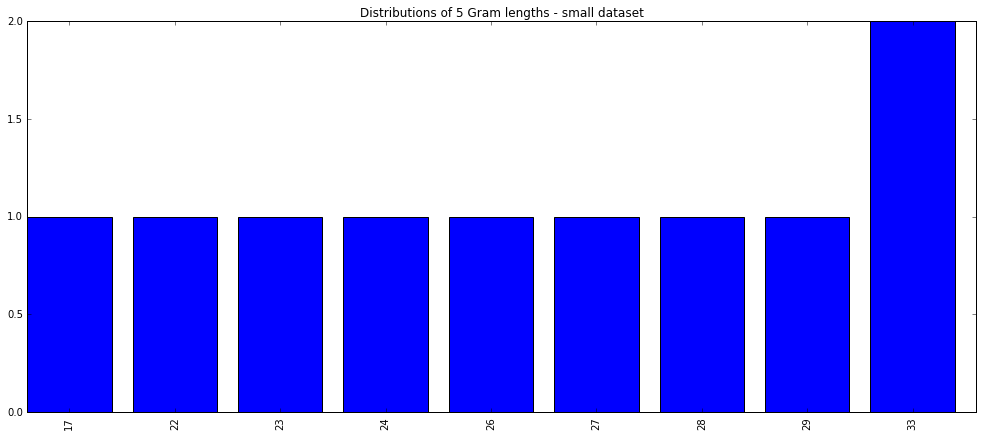

In [16]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("distribution_mini.txt").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths - small dataset")
pl.show()

__On the full data set:__

In [8]:
!time python distribution.py -r hadoop hdfs:///tmp/hw5b/gigantor_file.txt --no-output --cleanup NONE

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Creating temp directory /tmp/distribution.hyeramoon.20170222.183514.143641
Copying local files to hdfs:///user/hyeramoon/tmp/mrjob/distribution.hyeramoon.20170222.183514.143641/files/...
Detected hadoop configuration property names that do not match hadoop version 2.7.2:
The have been translated as follows
 mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob8019259597801222589.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.co

In [18]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob/distribution.hyeramoon.20170222.183514.143641/output

Found 2 items
-rw-r--r--   3 hyeramoon users          0 2017-02-20 19:30 /user/hyeramoon/tmp/mrjob/distribution.hyeramoon.20170220.192401.813338/output/_SUCCESS
-rw-r--r--   3 hyeramoon users        624 2017-02-20 19:30 /user/hyeramoon/tmp/mrjob/distribution.hyeramoon.20170220.192401.813338/output/part-00000


In [21]:
!hdfs dfs -cat /user/hyeramoon/tmp/mrjob/distribution.hyeramoon.20170222.183514.143641/output/part-00000 > \
distribution.txt

In [9]:
!hdfs dfs -rm -r /user/hyeramoon/tmp/mrjob/*

17/02/22 18:51:03 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/tmp/mrjob/distribution.hyeramoon.20170222.183514.143641' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/.Trash/Current


## Distribution MRJob stats

    Altiscale Hadoop  

    RUNNING for 536s ~= 9 minutes  
    Launched map tasks=8  
    Launched reduce tasks=1   

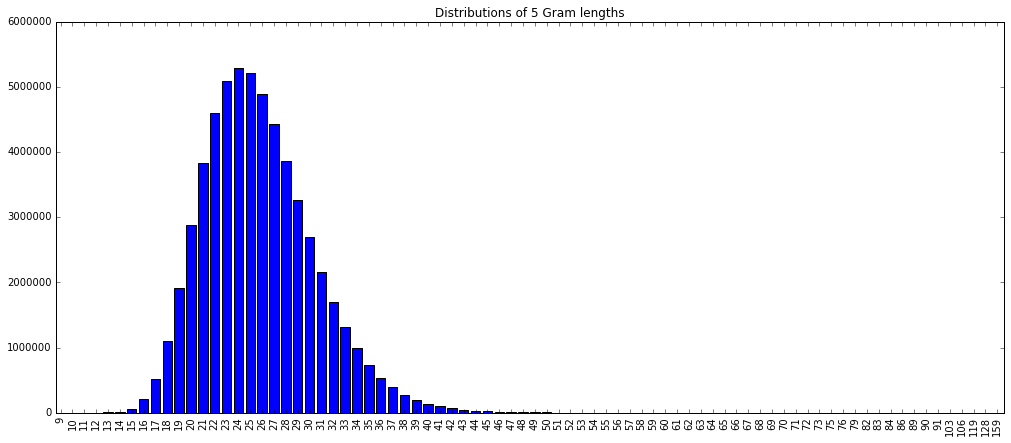

In [22]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("distribution.txt").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths")
pl.show()

## 3.  HW5.5  <a name="5.5"></a> Synonym detection over 2Gig of Data with extra Preprocessing steps (HW5.3 plus some preprocessing)   (Phase 2)
[Back to Table of Contents](#TOC)

For the remainder of this assignment please feel free to eliminate stop words from your analysis

>There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> from nltk.corpus import stopwords
 stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

### 2: A large subset of the Google n-grams dataset as was described above

For each HW 5.4 -5.5.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with your system.

In this part of the assignment we will focus on developing methods for detecting synonyms, using the Google 5-grams dataset. At a high level:


1. remove stopwords
2. get 10,0000 most frequent
3. get 1000 (9001-10000) features
3. build stripes

To accomplish this you must script two main tasks using MRJob:


__TASK (1)__ Build stripes for the most frequent 10,000 words using cooccurence information based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


__TASK (2)__ Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

#### Design notes for TASK (1)
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for TASK (2).

#### Design notes for _TASK (2)_
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!

## Example MR stats: (report times!)
    took ~11 minutes on 5 m3.xlarge nodes
    Data-local map tasks=188
	Launched map tasks=190
	Launched reduce tasks=15
	Other local map tasks=2

In [ ]:
# START STUDENT CODE 5.5
# ADD OR REMOVE CELLS AS NEEDED

In [ ]:
# Step 1: build file with 10,000 most frequent words

In [26]:
%%writefile mostFrequentWords10k.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostFrequentWords10k(MRJob):
    
    n = 10000
    
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.job.reduces':'1'  # Note: one reducer suffice since each partition from previous MRJob only
                                      # emits n lines
        }
        return[
            MRStep(
                mapper_init = self.mapper_init,
                mapper = self.mapper,
                combiner = self.combiner,
                reducer_init = self.reducer_init,
                reducer = self.reducer,
                reducer_final = self.reducer_final
            ),
            MRStep(
                jobconf = JOBCONF_STEP,
                reducer_init = self.reducer_top_init,
                reducer = self.reducer_top,
                reducer_final = self.reducer_top_final
            )

        ]
    
    def mapper_init(self):
        self.stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
                        'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
                        'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
                        'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
                        'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                        'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
                        'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
                        'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
                        'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
                        'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
                        'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
                        'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

    
    def mapper(self, _, line):
        self.increment_counter('group', 'Num_mapper_calls', 1)
        ngram, count, other = line.strip().split('\t',2)
        words = ngram.split(" ")
        count = int(count)
        for word in words:
            if word.lower() not in self.stopwords:
                yield str(word).lower(), count
           
        
    def combiner(self,word, counts):
        self.increment_counter('group', 'Num_combiner_calls', 1)
        yield word, sum(counts)
    
    
    def reducer_init(self):
        self.wordcounts_per_partition = [["None", 0]] * self.n
            
                
    def reducer(self, word, counts):
        count = sum(counts)
        index = -1
        for i in range(self.n):
            if count > self.wordcounts_per_partition[i][1]:  # note: number in counts in increasing order
                index = i  # find where to insert the wordcount in the count list
            else:
                break
        if index != -1:
            self.wordcounts_per_partition.insert(index+1, [word, count])
            self.wordcounts_per_partition = self.wordcounts_per_partition[1:self.n+1]  # take the 10 items with largest count out of 11 items

        
    def reducer_final(self):
        self.increment_counter('group', 'Num_reducer_calls', 1)
        
        for i in range(self.n-1,-1,-1):
            yield self.wordcounts_per_partition[i][0], self.wordcounts_per_partition[i][1]  # most frequent words 
                                                                                            # per partition
    
        
    def reducer_top_init(self):
        self.wordcounts_total = [["None", 0]] * self.n
    
    
    def reducer_top(self, word, counts):
        count = sum(counts)
        index = -1
        for i in range(self.n):
            if count > self.wordcounts_total[i][1]:  # note: number in counts in increasing order
                index = i  # find where to insert the wordcount in the count list
            else:
                break
        if index != -1:
            self.wordcounts_total.insert(index+1, [word, count])
            self.wordcounts_total = self.wordcounts_total[1:self.n+1]  # take n items with largest count out of n+1 items
            
            
    def reducer_top_final(self):
        self.increment_counter('group', 'Num_reducer2_calls', 1)
        
        for i in range(self.n-1,-1,-1):
            yield self.wordcounts_total[i][0], self.wordcounts_total[i][1]  # top most frequent words 
    
        
        
if __name__ == '__main__':
    mostFrequentWords10k.run()

Overwriting mostFrequentWords10k.py


In [24]:
!chmod a+x mostFrequentWords10k.py

In [27]:
!python mostFrequentWords10k.py -r hadoop hdfs:///tmp/hw5b/gigantor_file.txt --no-output --cleanup NONE

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Creating temp directory /tmp/mostFrequentWords10k.hyeramoon.20170220.215018.097815
Copying local files to hdfs:///user/hyeramoon/tmp/mrjob/mostFrequentWords10k.hyeramoon.20170220.215018.097815/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob9056197482831977807.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/t

In [28]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob/mostFrequentWords10k.hyeramoon.20170220.215018.097815/output

Found 2 items
-rw-r--r--   3 hyeramoon users          0 2017-02-20 22:05 /user/hyeramoon/tmp/mrjob/mostFrequentWords10k.hyeramoon.20170220.215018.097815/output/_SUCCESS
-rw-r--r--   3 hyeramoon users     176976 2017-02-20 22:05 /user/hyeramoon/tmp/mrjob/mostFrequentWords10k.hyeramoon.20170220.215018.097815/output/part-00000


In [29]:
!hdfs dfs -cat /user/hyeramoon/tmp/mrjob/mostFrequentWords10k.hyeramoon.20170220.215018.097815/output/part-00000 \
> top10k.txt

In [76]:
!hdfs dfs -rm -r /user/hyeramoon/tmp/mrjob/mostFrequentWords10k.hyeramoon.20170220.215018.097815/output

17/02/21 03:03:46 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/tmp/mrjob/mostFrequentWords10k.hyeramoon.20170220.215018.097815/output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/.Trash/Current


In [30]:
!head -5 top10k.txt
!tail -5 top10k.txt

"one"	180195771
"would"	139313915
"time"	126853684
"may"	108486904
"part"	79528921
"constituting"	133165
"foramen"	133131
"laboratories"	133058
"analyst"	133044
"atlas"	132983


In [35]:
%%writefile buildStripes10k.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
import itertools
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.job import MRStep

class MRbuildStripes10k(MRJob):
  
    
    def steps(self):
        return[
            MRStep(
                mapper_init = self.mapper_init,
                mapper = self.mapper,
                reducer = self.reducer
            )
        ]
    
    
    def mapper_init(self):
        self.stripes = {}
        self.top10k = []
        #with open("TEST10k.txt", "r") as top10file: # for small dataset test
        with open("top10k.txt", "r") as top10file:  #for actual dataset
            for line in top10file:
                line = line.strip()
                word, count = line.split('\t')
                word = word.strip("\"")
                self.top10k.append(word)
        #self.basis1k = self.top10k[7:10]  # for for small dataset test
        self.basis1k = self.top10k[9001:10000]  #for actual dataset
        self.top10k = set(self.top10k)  # to speed up the search of words in this list
        self.basis1k = set(self.basis1k)  # to speed up the search of words in this list
        
        
    def mapper(self, _, line):
        line = line.strip().lower()
        ngram, count, other = line.split('\t',2)
        count = int(count)
        words = ngram.split(' ')
        words = [word for word in words if word in self.top10k]
        self.stripes = {}
                
        for subset in itertools.permutations(sorted(words), 2):  #instead of combinations to keep symmetry
            if subset[1] in self.basis1k:
                if subset[0] == subset[1]:  # in case two same words in a line
                    continue
                elif subset[0] not in self.stripes.keys():
                    self.stripes[subset[0]] = {}
                    self.stripes[subset[0]][subset[1]] = count
                elif subset[1] not in self.stripes[subset[0]]:
                    self.stripes[subset[0]][subset[1]] = count
                else:
                    self.stripes[subset[0]][subset[1]] += count

        for key in self.stripes.keys():
            yield key, self.stripes[key]
    
        
    def reducer(self, key, values):
        temp_stripes = {}
        for value in values:
            for word, count in value.items():
                temp_stripes[word] = temp_stripes.get(word,0) + count
        yield key, temp_stripes
  

  #END SUDENT CODE531_STRIPES   
    
if __name__ == '__main__':
    MRbuildStripes10k.run()

Overwriting buildStripes10k.py


In [32]:
!chmod a+x buildStripes10k.py

In [36]:
!python buildStripes10k.py -r hadoop hdfs:///tmp/hw5b/gigantor_file.txt --file top10k.txt --no-output --cleanup NONE

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Creating temp directory /tmp/buildStripes10k.hyeramoon.20170220.230939.850969
Copying local files to hdfs:///user/hyeramoon/tmp/mrjob/buildStripes10k.hyeramoon.20170220.230939.850969/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob2466389826870904997.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
 

In [37]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob/buildStripes10k.hyeramoon.20170220.230939.850969/output

Found 2 items
-rw-r--r--   3 hyeramoon users          0 2017-02-20 23:13 /user/hyeramoon/tmp/mrjob/buildStripes10k.hyeramoon.20170220.230939.850969/output/_SUCCESS
-rw-r--r--   3 hyeramoon users    9284147 2017-02-20 23:13 /user/hyeramoon/tmp/mrjob/buildStripes10k.hyeramoon.20170220.230939.850969/output/part-00000


In [38]:
!hdfs dfs -cat /user/hyeramoon/tmp/mrjob/buildStripes10k.hyeramoon.20170220.230939.850969/output/part-00000 > \
stripes.txt
!head -5 stripes.txt

"ab"	{"binary": 76, "chord": 1006, "parallels": 89, "subscribed": 44, "conveying": 273, "residential": 77, "consul": 48, "amplifier": 91, "ce": 58, "narratives": 89, "terminals": 141, "wires": 51, "est": 256, "qui": 1445, "lever": 77}
"abandon"	{"misfortunes": 46, "inducing": 277, "unconstitutional": 55, "pursuits": 117, "athenians": 68, "dearest": 110, "logically": 46, "worldly": 46, "habitation": 50, "illusions": 200, "forts": 53, "holdings": 40, "resolving": 113, "commandment": 62, "glowing": 138, "peru": 124, "defenders": 45, "francs": 185, "renounce": 46, "collateral": 57, "oblige": 217, "warranted": 89, "spoil": 51, "discouraged": 74, "vastly": 49, "herds": 74, "unwillingness": 212, "vietnamese": 52, "persuading": 158, "honestly": 70, "careless": 181, "silly": 74, "sinner": 55}
"abandoned"	{"alexandria": 98, "travellers": 71, "humiliation": 46, "tents": 101, "metaphysical": 58, "forts": 51, "pursuits": 56, "athenians": 90, "traitor": 132, "enumeration": 61, "habitation": 61, "ana

In [41]:
%%writefile invertedIndex10k.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-


from __future__ import division
import collections
import re
import json
import math
#import numpy as np commented since not supported by Hadoop Python version
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.protocol import JSONProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRinvertedIndex10k(MRJob):
    INPUT_PROTOCOL = JSONProtocol

    def steps(self):
        return[
            MRStep(
                mapper=self.mapper,
                reducer=self.reducer
            )
        ]
    
    def mapper(self, key_word, stripes):
        words = stripes.keys()
        _len = len(words)
        for word in words:
        # Store the length of the document to use with JACCARD (|A| + |B|)
            yield word, (key_word, _len)

        
    def reducer(self, word, values):        
        d = collections.defaultdict(list)
        for value in values:
            d[word].append(value)
        yield word, d[word]

        
if __name__ == '__main__':
    MRinvertedIndex10k.run() 

Writing invertedIndex10k.py


In [42]:
!chmod a+x invertedIndex10k.py

In [44]:
!python invertedIndex10k.py -r hadoop \
hdfs:///user/hyeramoon/tmp/mrjob/buildStripes10k.hyeramoon.20170220.230939.850969/output/part-00000 \
    --no-output --cleanup NONE

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Creating temp directory /tmp/invertedIndex10k.hyeramoon.20170220.234727.351327
Copying local files to hdfs:///user/hyeramoon/tmp/mrjob/invertedIndex10k.hyeramoon.20170220.234727.351327/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob22980440023588590.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
 

In [80]:
# buildStripe outputs not needed anymore since used in inverted index
!hdfs dfs -rm -r /user/hyeramoon/tmp/mrjob/buildStripes10k*/output

17/02/21 03:08:01 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/tmp/mrjob/buildStripes10k.hyeramoon.20170220.224220.435157/output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/.Trash/Current


In [45]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob/invertedIndex10k.hyeramoon.20170220.234727.351327/output

Found 2 items
-rw-r--r--   3 hyeramoon users          0 2017-02-20 23:48 /user/hyeramoon/tmp/mrjob/invertedIndex10k.hyeramoon.20170220.234727.351327/output/_SUCCESS
-rw-r--r--   3 hyeramoon users    9467513 2017-02-20 23:48 /user/hyeramoon/tmp/mrjob/invertedIndex10k.hyeramoon.20170220.234727.351327/output/part-00000


In [48]:
!hdfs dfs -cat /user/hyeramoon/tmp/mrjob/invertedIndex10k.hyeramoon.20170220.234727.351327/output/part-00000 > \
invertedindex.txt

In [11]:
%%writefile similarity10k.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
#import numpy as np  commented since not supported by Hadoop Python version
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRsimilarity10k(MRJob):
  
    MRJob.SORT_VALUES
    
    def steps(self):
        JOBCONF_STEP1 = {
            'mapreduce.job.maps': 100,
            'mapreduce.job.reduces' : 50     
        }
        JOBCONF_STEP2 = { 
                # Must use -r hadoop mode for this sorting to work #
                'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                'mapreduce.partition.keycomparator.options':'-k1,1nr',
                'mapreduce.job.reduces' : 1
        }

        return [
            MRStep(jobconf=JOBCONF_STEP1,
                   mapper = self.mapper_pair_sim,
                   reducer = self.reducer_pair_sim
                  ),
            MRStep(jobconf=JOBCONF_STEP2,
                  mapper=None,
                  reducer=self.reducer_sort)
        ]
        
    def mapper_pair_sim(self, _, line):
        line = line.strip()
        index,posting = line.split("\t")
        posting = json.loads(posting)
        
        X = map(lambda x: x[0]+"."+str(x[1]) , posting)
        
        # taking advantage of symetry, output only (a,b), but not (b,a)
        for subset in itertools.combinations(sorted(set(X)), 2):
            yield subset[0]+"."+subset[1], 1
        
            
    def reducer_pair_sim(self,key,values):
        word1, word1_len, word2, word2_len = key.split(".")
        t =sum(values)
       
        cosine = (1.0/(float(word1_len)**0.5) * 1.0/(float(word2_len)**0.5))*t
        jaccard = t / ( int(word1_len) + int(word2_len) - t )
        overlap = t / min(int(word1_len), int(word2_len))
        dice = 2 * t / ( int(word1_len) + int(word2_len))
        avg = (jaccard + cosine + overlap + dice) / 4
        #avg = (jaccard + cosine) / 2
        
        # rounding to 6 decimals
        #avg = round(avg, 6)
        #cosine = round(cosine, 6)
        #jaccard = round(jaccard, 6)
        #overlap = round(overlap, 6)
        #dice = round(dice, 6)
        
        yield cosine, (word1+" - "+word2, jaccard, overlap, dice, avg)
    
    
    def reducer_sort(self,key,values):
        for value in values:
            yield key, value


if __name__ == '__main__':
    MRsimilarity10k.run()

Overwriting similarity10k.py


In [9]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob

Found 2 items
drwxr-xr-x   - hyeramoon users          0 2017-02-21 17:05 /user/hyeramoon/tmp/mrjob/similarity10k.hyeramoon.20170221.153348.042047
drwxr-xr-x   - hyeramoon users          0 2017-02-21 22:03 /user/hyeramoon/tmp/mrjob/similarity10k.hyeramoon.20170221.172913.560367


In [3]:
!hdfs dfs -rm -r /user/hyeramoon/tmp/mrjob/*

17/02/21 15:32:51 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/tmp/mrjob/similarity10k.hyeramoon.20170221.043818.424550' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/.Trash/Current
17/02/21 15:32:52 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/tmp/mrjob/similarity10k.hyeramoon.20170221.050131.587630' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/.Trash/Current
17/02/21 15:32:52 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/tmp/mrjob/similarity10k.hyeramoon.20170221.052601.929587' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/hyeramoon/.

In [84]:
!chmod a+x similarity10k.py

In [12]:
#trying 4 measures run
!python similarity10k.py -r hadoop invertedindex.txt --no-output --cleanup NONE

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.2
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar
Creating temp directory /tmp/similarity10k.hyeramoon.20170222.015519.504577
Copying local files to hdfs:///user/hyeramoon/tmp/mrjob/similarity10k.hyeramoon.20170222.015519.504577/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.2/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar] /tmp/streamjob2730643151149131944.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Con

In [13]:
!hdfs dfs -ls /user/hyeramoon/tmp/mrjob/similarity10k.hyeramoon.20170222.015519.504577/output

Found 2 items
-rw-r--r--   3 hyeramoon users          0 2017-02-22 04:12 /user/hyeramoon/tmp/mrjob/similarity10k.hyeramoon.20170222.015519.504577/output/_SUCCESS
-rw-r--r--   3 hyeramoon users 3669467414 2017-02-22 04:12 /user/hyeramoon/tmp/mrjob/similarity10k.hyeramoon.20170222.015519.504577/output/part-00000


In [16]:
!hdfs dfs -cat /user/hyeramoon/tmp/mrjob/similarity10k.hyeramoon.20170222.015519.504577/output/part-00000 > \
similarity10k.txt

In [17]:
!head -5 similarity10k.txt

0.95062310152124585	["may - one", 0.90533736153071498, 0.97505422993492408, 0.95031712473572938, 0.94533295443065357]
0.94337186406186457	["one - time", 0.8913705583756345, 0.98320268756998885, 0.94256575415995703, 0.94012771604186129]
0.93201683578479955	["one - well", 0.87109768378650554, 0.97409909909909909, 0.93110871905274484, 0.92708058443078722]
0.92060442486666916	["may - well", 0.85261003070624364, 0.93806306306306309, 0.92044198895027629, 0.90792987689656302]
0.91567278999093071	["first - one", 0.84077079107505071, 0.9810650887573964, 0.91349862258953163, 0.91275182310322744]


In [18]:
!head -1000 similarity10k.txt > similarity10ksmall.txt

In [19]:
import json
sortedSims = []
with open('similarity10ksmall.txt', 'r') as simfile:
    for line in simfile:
        key, stripe = line.strip().split('\t',1)
        stripe =json.loads(stripe)
        sortedSims.append([stripe[0], key, stripe[1], stripe[2], stripe[3], stripe[4]])

In [20]:
!tail -1000 similarity10k.txt > similarity10ksmall_bottom.txt

In [21]:
import json
sortedSimsbottom = []
with open('similarity10ksmall_bottom.txt', 'r') as simfile:
    for line in simfile:
        key, stripe = line.strip().split('\t',1)
        stripe =json.loads(stripe)
        sortedSims.append([stripe[0], key, stripe[1], stripe[2], stripe[3], stripe[4]])

In [ ]:
# END STUDENT CODE 5.5

In [22]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

for stripe in sortedSims[:20]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

print '—'*117

for stripe in sortedSims[-20:]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )



Top/Bottom 20 results - Similarity measures - sorted by cosine
(From the entire data set)
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                          pair |         cosine |        jaccard |        overlap |           dice |        average
---------------------------------------------------------------------------------------------------------------------
                     may - one |       0.950623 |       0.905337 |       0.975054 |       0.950317 |       0.945333
                    one - time |       0.943372 |       0.891371 |       0.983203 |       0.942566 |       0.940128
                    one - well |       0.932017 |       0.871098 |       0.974099 |       0.931109 |       0.927081
                    may - well |       0.920604 |       0.852610 |       0.938063 |       0.920442 |       0.907930
                   first - one |       0.915673 |       0.840771 |       0.981065 |       0.9

In [ ]:
Top/Bottom 20 results - Similarity measures - sorted by cosine
(From the entire data set)
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                          pair |         cosine |        jaccard |        overlap |           dice |        average
---------------------------------------------------------------------------------------------------------------------
                   cons - pros |       0.894427 |       0.800000 |       1.000000 |       0.888889 |       0.895829
            forties - twenties |       0.816497 |       0.666667 |       1.000000 |       0.800000 |       0.820791
                    own - time |       0.809510 |       0.670563 |       0.921168 |       0.802799 |       0.801010
                 little - time |       0.784197 |       0.630621 |       0.926101 |       0.773473 |       0.778598
                  found - time |       0.783434 |       0.636364 |       0.883788 |       0.777778 |       0.770341
                 nova - scotia |       0.774597 |       0.600000 |       1.000000 |       0.750000 |       0.781149
                   hong - kong |       0.769800 |       0.615385 |       0.888889 |       0.761905 |       0.758995
                   life - time |       0.769666 |       0.608789 |       0.925081 |       0.756829 |       0.765091
                  time - world |       0.755476 |       0.585049 |       0.937500 |       0.738209 |       0.754058
                  means - time |       0.752181 |       0.587117 |       0.902597 |       0.739854 |       0.745437
                   form - time |       0.749943 |       0.588418 |       0.876733 |       0.740885 |       0.738995
       infarction - myocardial |       0.748331 |       0.560000 |       1.000000 |       0.717949 |       0.756570
                 people - time |       0.745788 |       0.573577 |       0.923875 |       0.729010 |       0.743063
                 angeles - los |       0.745499 |       0.586207 |       0.850000 |       0.739130 |       0.730209
                  little - own |       0.739343 |       0.585834 |       0.767296 |       0.738834 |       0.707827
                    life - own |       0.737053 |       0.582217 |       0.778502 |       0.735951 |       0.708430
          anterior - posterior |       0.733388 |       0.576471 |       0.790323 |       0.731343 |       0.707881
                  power - time |       0.719611 |       0.533623 |       0.933586 |       0.695898 |       0.720680
              dearly - install |       0.707107 |       0.500000 |       1.000000 |       0.666667 |       0.718443
                   found - own |       0.704802 |       0.544134 |       0.710949 |       0.704776 |       0.666165
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
           arrival - essential |       0.008258 |       0.004098 |       0.009615 |       0.008163 |       0.007534
         governments - surface |       0.008251 |       0.003534 |       0.014706 |       0.007042 |       0.008383
                king - lesions |       0.008178 |       0.003106 |       0.017857 |       0.006192 |       0.008833
              clinical - stood |       0.008178 |       0.003831 |       0.011905 |       0.007634 |       0.007887
               till - validity |       0.008172 |       0.003367 |       0.015625 |       0.006711 |       0.008469
            evidence - started |       0.008159 |       0.003802 |       0.012048 |       0.007576 |       0.007896
               forces - record |       0.008152 |       0.003876 |       0.011364 |       0.007722 |       0.007778
               primary - stone |       0.008146 |       0.004065 |       0.009091 |       0.008097 |       0.007350
             beneath - federal |       0.008134 |       0.004082 |       0.008403 |       0.008130 |       0.007187
                factors - rose |       0.008113 |       0.004032 |       0.009346 |       0.008032 |       0.007381
           evening - functions |       0.008069 |       0.004049 |       0.008333 |       0.008065 |       0.007129
                   bone - told |       0.008061 |       0.003704 |       0.012346 |       0.007380 |       0.007873
             building - occurs |       0.008002 |       0.003891 |       0.010309 |       0.007752 |       0.007489
                 company - fig |       0.007913 |       0.003257 |       0.015152 |       0.006494 |       0.008204
               chronic - north |       0.007803 |       0.003268 |       0.014493 |       0.006515 |       0.008020
             evaluation - king |       0.007650 |       0.003030 |       0.015625 |       0.006042 |       0.008087
             resulting - stood |       0.007650 |       0.003663 |       0.010417 |       0.007299 |       0.007257
                 agent - round |       0.007515 |       0.003289 |       0.012821 |       0.006557 |       0.007546
         afterwards - analysis |       0.007387 |       0.003521 |       0.010204 |       0.007018 |       0.007032
            posterior - spirit |       0.007156 |       0.002660 |       0.016129 |       0.005305 |       0.007812

## 3.  HW5.6  <a name="5.6"></a> Evaluation of synonyms that your discovered
[Back to Table of Contents](#TOC)


In this part of the assignment you will evaluate the success of you synonym detector (developed in response to HW5.4).
Take the top 1,000 closest/most similar/correlative pairs of words as determined by your measure in HW5.4, and use the synonyms function in the accompanying python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

### Calculate performance measures:
$$Precision (P) = \frac{TP}{TP + FP} $$  
$$Recall (R) = \frac{TP}{TP + FN} $$  
$$F1 = \frac{2 * ( precision * recall )}{precision + recall}$$


We calculate Precision by counting the number of hits and dividing by the number of occurances in our top1000 (opportunities)   
We calculate Recall by counting the number of hits, and dividing by the number of synonyms in wordnet (syns)


Other diagnostic measures not implemented here:  https://en.wikipedia.org/wiki/F1_score#Diagnostic_Testing

In [4]:
''' Performance measures '''
from __future__ import division
import numpy as np
import json
import nltk
from nltk.corpus import wordnet as wn
import sys
#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()
hits = []

TP = 0
FP = 0

TOTAL = 0
flag = False # so we don't double count, but at the same time don't miss hits

top1000sims = []
with open("similarity10ksmall.txt","r") as f:
    for line in f.readlines():

        line = line.strip()
        #avg,lisst = line.split("\t")
        cosine,lisst = line.split("\t")
        lisst = json.loads(lisst)
        #lisst.append(avg)
        lisst.append(cosine)
        top1000sims.append(lisst)
    

measures = {}
not_in_wordnet = []

for line in top1000sims:
    TOTAL += 1

    pair = line[0]
    words = pair.split(" - ")
    
    for word in words:
        if word not in measures:
            measures[word] = {"syns":0,"opps": 0,"hits":0}
        measures[word]["opps"] += 1 
    
    syns0 = synonyms(words[0])
    measures[words[1]]["syns"] = len(syns0)
    if len(syns0) == 0:
        not_in_wordnet.append(words[0])
        
    if words[1] in syns0:
        TP += 1
        hits.append(line)
        flag = True
        measures[words[1]]["hits"] += 1
        
        
        
    syns1 = synonyms(words[1]) 
    measures[words[0]]["syns"] = len(syns1)
    if len(syns1) == 0:
        not_in_wordnet.append(words[1])

    if words[0] in syns1:
        if flag == False:
            TP += 1
            hits.append(line)
            measures[words[0]]["hits"] += 1
            
    flag = False    

precision = []
recall = []
f1 = []

for key in measures:
    p,r,f = 0,0,0
    if measures[key]["hits"] > 0 and measures[key]["syns"] > 0:
        p = measures[key]["hits"]/measures[key]["opps"]
        r = measures[key]["hits"]/measures[key]["syns"]
        f = 2 * (p*r)/(p+r)
    
    # For calculating measures, only take into account words that have synonyms in wordnet
    if measures[key]["syns"] > 0:
        precision.append(p)
        recall.append(r)
        f1.append(f)

    
# Take the mean of each measure    
print "—"*110    
print "Number of Hits:",TP, "out of top",TOTAL
print "Number of words without synonyms:",len(not_in_wordnet)
print "—"*110 
print "Precision\t", np.mean(precision)
print "Recall\t\t", np.mean(recall)
print "F1\t\t", np.mean(f1)
print "—"*110  

print "Words without synonyms:"
print "-"*100

for word in not_in_wordnet:
    print synonyms(word),word

    

——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 9 out of top 1000
Number of words without synonyms: 237
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.00439994397663
Recall		0.0195671602481
F1		0.00494592473319
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] would
[] would
[] would
[] upon
[] could
[] would
[] would
[] upon
[] would
[] would
[] upon
[] could
[] upon
[] would
[] would
[] could
[] could
[] upon
[] upon
[] would
[] would
[] would
[] would
[] upon
[] could
[] could
[] upon
[] would
[] would
[] upon
[] hong
[] kong
[] could
[] could
[] could
[] without
[] could
[] would
[] could
[] upon
[] without
[] upon
[] would
[] would
[] would
[]

### Sample output

In [ ]:
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 31 out of top 1000
Number of words without synonyms: 67
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.0280214404967
Recall		0.0178598869579
F1		0.013965517619
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] scotia
[] hong
[] kong
[] angeles
[] los
[] nor
[] themselves
[] 
.......